## Dependencies

In [1]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from scripts_step_lr_schedulers import *

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

In [2]:
class RectifiedAdam(tf.keras.optimizers.Optimizer):
    """Variant of the Adam optimizer whose adaptive learning rate is rectified
    so as to have a consistent variance.
    It implements the Rectified Adam (a.k.a. RAdam) proposed by
    Liyuan Liu et al. in [On The Variance Of The Adaptive Learning Rate
    And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf).
    Example of usage:
    ```python
    opt = tfa.optimizers.RectifiedAdam(lr=1e-3)
    ```
    Note: `amsgrad` is not described in the original paper. Use it with
          caution.
    RAdam is not a placement of the heuristic warmup, the settings should be
    kept if warmup has already been employed and tuned in the baseline method.
    You can enable warmup by setting `total_steps` and `warmup_proportion`:
    ```python
    opt = tfa.optimizers.RectifiedAdam(
        lr=1e-3,
        total_steps=10000,
        warmup_proportion=0.1,
        min_lr=1e-5,
    )
    ```
    In the above example, the learning rate will increase linearly
    from 0 to `lr` in 1000 steps, then decrease linearly from `lr` to `min_lr`
    in 9000 steps.
    Lookahead, proposed by Michael R. Zhang et.al in the paper
    [Lookahead Optimizer: k steps forward, 1 step back]
    (https://arxiv.org/abs/1907.08610v1), can be integrated with RAdam,
    which is announced by Less Wright and the new combined optimizer can also
    be called "Ranger". The mechanism can be enabled by using the lookahead
    wrapper. For example:
    ```python
    radam = tfa.optimizers.RectifiedAdam()
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    ```
    """

    def __init__(self,
                 learning_rate=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=1e-7,
                 weight_decay=0.,
                 amsgrad=False,
                 sma_threshold=5.0,
                 total_steps=0,
                 warmup_proportion=0.1,
                 min_lr=0.,
                 name='RectifiedAdam',
                 **kwargs):
        r"""Construct a new RAdam optimizer.
        Args:
            learning_rate: A `Tensor` or a floating point value. or a schedule
                that is a `tf.keras.optimizers.schedules.LearningRateSchedule`
                The learning rate.
            beta_1: A float value or a constant float tensor.
                The exponential decay rate for the 1st moment estimates.
            beta_2: A float value or a constant float tensor.
                The exponential decay rate for the 2nd moment estimates.
            epsilon: A small constant for numerical stability.
            weight_decay: A floating point value. Weight decay for each param.
            amsgrad: boolean. Whether to apply AMSGrad variant of this
                algorithm from the paper "On the Convergence of Adam and
                beyond".
            sma_threshold. A float value.
                The threshold for simple mean average.
            total_steps: An integer. Total number of training steps.
                Enable warmup by setting a positive value.
            warmup_proportion: A floating point value.
                The proportion of increasing steps.
            min_lr: A floating point value. Minimum learning rate after warmup.
            name: Optional name for the operations created when applying
                gradients. Defaults to "RectifiedAdam".
            **kwargs: keyword arguments. Allowed to be {`clipnorm`,
                `clipvalue`, `lr`, `decay`}. `clipnorm` is clip gradients
                by norm; `clipvalue` is clip gradients by value, `decay` is
                included for backward compatibility to allow time inverse
                decay of learning rate. `lr` is included for backward
                compatibility, recommended to use `learning_rate` instead.
        """
        super(RectifiedAdam, self).__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self._set_hyper('decay', self._initial_decay)
        self._set_hyper('weight_decay', weight_decay)
        self._set_hyper('sma_threshold', sma_threshold)
        self._set_hyper('total_steps', float(total_steps))
        self._set_hyper('warmup_proportion', warmup_proportion)
        self._set_hyper('min_lr', min_lr)
        self.epsilon = epsilon or tf.keras.backend.epsilon()
        self.amsgrad = amsgrad
        self._initial_weight_decay = weight_decay
        self._initial_total_steps = total_steps

    def _create_slots(self, var_list):
        for var in var_list:
            self.add_slot(var, 'm')
        for var in var_list:
            self.add_slot(var, 'v')
        if self.amsgrad:
            for var in var_list:
                self.add_slot(var, 'vhat')

    def set_weights(self, weights):
        params = self.weights
        num_vars = int((len(params) - 1) / 2)
        if len(weights) == 3 * num_vars + 1:
            weights = weights[:len(params)]
        super(RectifiedAdam, self).set_weights(weights)

    def _resource_apply_dense(self, grad, var):
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype)
        m = self.get_slot(var, 'm')
        v = self.get_slot(var, 'v')
        beta_1_t = self._get_hyper('beta_1', var_dtype)
        beta_2_t = self._get_hyper('beta_2', var_dtype)
        epsilon_t = tf.convert_to_tensor(self.epsilon, var_dtype)
        local_step = tf.cast(self.iterations + 1, var_dtype)
        beta_1_power = tf.pow(beta_1_t, local_step)
        beta_2_power = tf.pow(beta_2_t, local_step)

        if self._initial_total_steps > 0:
            total_steps = self._get_hyper('total_steps', var_dtype)
            warmup_steps = total_steps *\
                self._get_hyper('warmup_proportion', var_dtype)
            min_lr = self._get_hyper('min_lr', var_dtype)
            decay_steps = tf.maximum(total_steps - warmup_steps, 1)
            decay_rate = (min_lr - lr_t) / decay_steps
            lr_t = tf.where(
                local_step <= warmup_steps,
                lr_t * (local_step / warmup_steps),
                lr_t + decay_rate * tf.minimum(local_step - warmup_steps,
                                               decay_steps),
            )

        sma_inf = 2.0 / (1.0 - beta_2_t) - 1.0
        sma_t = sma_inf - 2.0 * local_step * beta_2_power / (
            1.0 - beta_2_power)

        m_t = m.assign(
            beta_1_t * m + (1.0 - beta_1_t) * grad,
            use_locking=self._use_locking)
        m_corr_t = m_t / (1.0 - beta_1_power)

        v_t = v.assign(
            beta_2_t * v + (1.0 - beta_2_t) * tf.square(grad),
            use_locking=self._use_locking)
        if self.amsgrad:
            vhat = self.get_slot(var, 'vhat')
            vhat_t = vhat.assign(
                tf.maximum(vhat, v_t), use_locking=self._use_locking)
            v_corr_t = tf.sqrt(vhat_t / (1.0 - beta_2_power))
        else:
            vhat_t = None
            v_corr_t = tf.sqrt(v_t / (1.0 - beta_2_power))

        r_t = tf.sqrt((sma_t - 4.0) / (sma_inf - 4.0) * (sma_t - 2.0) /
                      (sma_inf - 2.0) * sma_inf / sma_t)

        sma_threshold = self._get_hyper('sma_threshold', var_dtype)
        var_t = tf.where(sma_t >= sma_threshold,
                         r_t * m_corr_t / (v_corr_t + epsilon_t), m_corr_t)

        if self._initial_weight_decay > 0.0:
            var_t += self._get_hyper('weight_decay', var_dtype) * var

        var_update = var.assign_sub(
            lr_t * var_t, use_locking=self._use_locking)

        updates = [var_update, m_t, v_t]
        if self.amsgrad:
            updates.append(vhat_t)
        return tf.group(*updates)

    def _resource_apply_sparse(self, grad, var, indices):
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype)
        beta_1_t = self._get_hyper('beta_1', var_dtype)
        beta_2_t = self._get_hyper('beta_2', var_dtype)
        epsilon_t = tf.convert_to_tensor(self.epsilon, var_dtype)
        local_step = tf.cast(self.iterations + 1, var_dtype)
        beta_1_power = tf.pow(beta_1_t, local_step)
        beta_2_power = tf.pow(beta_2_t, local_step)

        if self._initial_total_steps > 0:
            total_steps = self._get_hyper('total_steps', var_dtype)
            warmup_steps = total_steps *\
                self._get_hyper('warmup_proportion', var_dtype)
            min_lr = self._get_hyper('min_lr', var_dtype)
            decay_steps = tf.maximum(total_steps - warmup_steps, 1)
            decay_rate = (min_lr - lr_t) / decay_steps
            lr_t = tf.where(
                local_step <= warmup_steps,
                lr_t * (local_step / warmup_steps),
                lr_t + decay_rate * tf.minimum(local_step - warmup_steps,
                                               decay_steps),
            )

        sma_inf = 2.0 / (1.0 - beta_2_t) - 1.0
        sma_t = sma_inf - 2.0 * local_step * beta_2_power / (
            1.0 - beta_2_power)

        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * (1 - beta_1_t)
        m_t = m.assign(m * beta_1_t, use_locking=self._use_locking)
        with tf.control_dependencies([m_t]):
            m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)
        m_corr_t = m_t / (1.0 - beta_1_power)

        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * (1 - beta_2_t)
        v_t = v.assign(v * beta_2_t, use_locking=self._use_locking)
        with tf.control_dependencies([v_t]):
            v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)

        if self.amsgrad:
            vhat = self.get_slot(var, 'vhat')
            vhat_t = vhat.assign(
                tf.maximum(vhat, v_t), use_locking=self._use_locking)
            v_corr_t = tf.sqrt(vhat_t / (1.0 - beta_2_power))
        else:
            vhat_t = None
            v_corr_t = tf.sqrt(v_t / (1.0 - beta_2_power))

        r_t = tf.sqrt((sma_t - 4.0) / (sma_inf - 4.0) * (sma_t - 2.0) /
                      (sma_inf - 2.0) * sma_inf / sma_t)

        sma_threshold = self._get_hyper('sma_threshold', var_dtype)
        var_t = tf.where(sma_t >= sma_threshold,
                         r_t * m_corr_t / (v_corr_t + epsilon_t), m_corr_t)

        if self._initial_weight_decay > 0.0:
            var_t += self._get_hyper('weight_decay', var_dtype) * var

        with tf.control_dependencies([var_t]):
            var_update = self._resource_scatter_add(
                var, indices, tf.gather(-lr_t * var_t, indices))

        updates = [var_update, m_t, v_t]
        if self.amsgrad:
            updates.append(vhat_t)
        return tf.group(*updates)

    def get_config(self):
        config = super(RectifiedAdam, self).get_config()
        config.update({
            'learning_rate':
            self._serialize_hyperparameter('learning_rate'),
            'beta_1':
            self._serialize_hyperparameter('beta_1'),
            'beta_2':
            self._serialize_hyperparameter('beta_2'),
            'decay':
            self._serialize_hyperparameter('decay'),
            'weight_decay':
            self._serialize_hyperparameter('weight_decay'),
            'sma_threshold':
            self._serialize_hyperparameter('sma_threshold'),
            'epsilon':
            self.epsilon,
            'amsgrad':
            self.amsgrad,
            'total_steps':
            self._serialize_hyperparameter('total_steps'),
            'warmup_proportion':
            self._serialize_hyperparameter('warmup_proportion'),
            'min_lr':
            self._serialize_hyperparameter('min_lr'),
        })
        return config

# Load data

In [3]:
# Unzip files
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96-aux/fold_1.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96-aux/fold_2.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96-aux/fold_3.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96-aux/fold_4.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96-aux/fold_5.tar.gz

fold_1/
fold_1/y_valid.npy
fold_1/x_valid_aux.npy
fold_1/y_train_mask.npy
fold_1/x_train_aux.npy
fold_1/x_valid.npy
fold_1/x_valid_aux2.npy
fold_1/y_valid_aux.npy
fold_1/y_train.npy
fold_1/y_train_aux.npy
fold_1/y_valid_mask.npy
fold_1/x_train.npy
fold_1/x_train_aux2.npy
fold_2/
fold_2/y_valid.npy
fold_2/x_valid_aux.npy
fold_2/y_train_mask.npy
fold_2/x_train_aux.npy
fold_2/x_valid.npy
fold_2/x_valid_aux2.npy
fold_2/y_valid_aux.npy
fold_2/y_train.npy
fold_2/y_train_aux.npy
fold_2/y_valid_mask.npy
fold_2/x_train.npy
fold_2/x_train_aux2.npy
fold_3/
fold_3/y_valid.npy
fold_3/x_valid_aux.npy
fold_3/y_train_mask.npy
fold_3/x_train_aux.npy
fold_3/x_valid.npy
fold_3/x_valid_aux2.npy
fold_3/y_valid_aux.npy
fold_3/y_train.npy
fold_3/y_train_aux.npy
fold_3/y_valid_mask.npy
fold_3/x_train.npy
fold_3/x_train_aux2.npy
fold_4/
fold_4/y_valid.npy
fold_4/x_valid_aux.npy
fold_4/y_train_mask.npy
fold_4/x_train_aux.npy
fold_4/x_valid.npy
fold_4/x_valid_aux2.npy
fold_4/y_valid_aux.npy
fold_4/y_train.npy
fo

In [4]:
database_base_path = '/kaggle/input/tweet-dataset-split-roberta-base-96-aux/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

,textID,text,selected_text,sentiment,jaccard,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,74,13,14,3,train,train,validation,train,train


# Model parameters

In [5]:
vocab_path = database_base_path + 'vocab.json'
merges_path = database_base_path + 'merges.txt'
base_path = '/kaggle/input/qa-transformers/roberta/'

config = {
  'MAX_LEN': 96,
  'BATCH_SIZE': 32,
  'EPOCHS': 4,
  'LEARNING_RATE': 3e-5,
  'ES_PATIENCE': 4,
  'question_size': 4,
  'N_FOLDS': 5,
  'base_model_path': base_path + 'roberta-base-tf_model.h5',
  'config_path': base_path + 'roberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [6]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

## Learning rate schedule

In [7]:
# lr_min = 1e-6
# lr_max = config['LEARNING_RATE']
# step_size = len(k_fold[k_fold['fold_1'] == 'train']) // config['BATCH_SIZE']
# total_steps = config['EPOCHS'] * step_size
# decay = .999

# rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
# y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=1, lr_start=lr_max, lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

# sns.set(style="whitegrid")
# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [8]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x_start = layers.Dropout(.1)(last_hidden_state) 
    x_start = layers.Dense(1)(x_start)
    x_start = layers.Flatten()(x_start)

    x_end = layers.Dropout(.1)(last_hidden_state) 
    x_end = layers.Dense(1)(x_end)
    x_end = layers.Flatten()(x_end)
    
    y_start = layers.Subtract()([x_start, x_end])
    y_start = layers.Activation('softmax', name='y_start')(x_start)
    
    y_end = layers.Subtract()([x_end, x_start])
    y_end = layers.Activation('softmax', name='y_end')(x_end)

    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    return model

# Train

In [9]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']
    
    ### Delete data dir
    shutil.rmtree(base_data_path)

    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss_start = loss_fn_start(y['y_start'], probabilities[0])
                loss_end = loss_fn_end(y['y_end'], probabilities[1])
                loss = tf.math.add(loss_start, loss_end)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # update metrics
            train_loss.update_state(loss)
            train_loss_start.update_state(loss_start)
            train_loss_end.update_state(loss_end)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss_start = loss_fn_start(y['y_start'], probabilities[0])
            loss_end = loss_fn_end(y['y_end'], probabilities[1])
            loss = tf.math.add(loss_start, loss_end)
            # update metrics
            valid_loss.update_state(loss)
            valid_loss_start.update_state(loss_start)
            valid_loss_end.update_state(loss_end)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    
    model = model_fn(config['MAX_LEN'])
    optimizer = RectifiedAdam(lr=config['LEARNING_RATE'], warmup_proportion=0.1, min_lr=1e-7, 
                              total_steps=(len(k_fold[k_fold['fold_1'] == 'train']) // config['BATCH_SIZE']) * config['EPOCHS'])
#     optimizer = optimizers.Adam(learning_rate=lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
#                                                                                        warmup_steps=1, lr_start=lr_max, 
#                                                                                        lr_max=lr_max, lr_min=lr_min, decay=decay))
    loss_fn_start = losses.categorical_crossentropy
    loss_fn_end = losses.categorical_crossentropy

    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    train_loss_start = metrics.Sum()
    valid_loss_start = metrics.Sum()
    train_loss_end = metrics.Sum()
    valid_loss_end = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'loss_start': train_loss_start, 'loss_end': train_loss_end, 
                    'val_loss': valid_loss, 'val_loss_start': valid_loss_start, 'val_loss_end': valid_loss_end, }
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], 
                         model_path, save_last=True)
    
    history_list.append(history)
    model.load_weights(model_path)
    
    # Make predictions
    train_preds = model.predict(list(x_train))
    valid_preds = model.predict(list(x_valid))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna(k_fold["text"], inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 1
Train for 687 steps, validate for 171 steps

EPOCH 1/4
time: 350.2s loss: 3.5911 loss_start: 1.6953 loss_end: 1.8958 val_loss: 1.7455 val_loss_start: 0.8862 val_loss_end: 0.8592
Saved model weights at "model_fold_1.h5"

EPOCH 2/4
time: 302.5s loss: 1.7853 loss_start: 0.9032 loss_end: 0.8822 val_loss: 1.5808 val_loss_start: 0.8391 val_loss_end: 0.7418
Saved model weights at "model_fold_1.h5"

EPOCH 3/4
time: 303.4s loss: 1.5910 loss_start: 0.8222 loss_end: 0.7688 val_loss: 1.5382 val_loss_start: 0.8047 val_loss_end: 0.7335
Saved model weights at "model_fold_1.h5"

EPOCH 4/4
time: 303.1s loss: 1.4681 loss_start: 0.7679 loss_end: 0.7002 val_loss: 1.5381 val_loss_start: 0.7999 val_loss_end: 0.7382
Training finished saved model weights at "last_model_fold_1.h5"

FOLD: 2
Train for 687 steps, validate for 171 steps

EPOCH 1/4
time: 351.9s loss: 3.4526 loss_start: 1.6548 loss_end: 1.7978 val_loss: 1.8134 val_loss_start: 0.9135 val_loss_end: 0.8999
Saved model weights at "model_fold_2.

# Model loss graph

Fold: 1


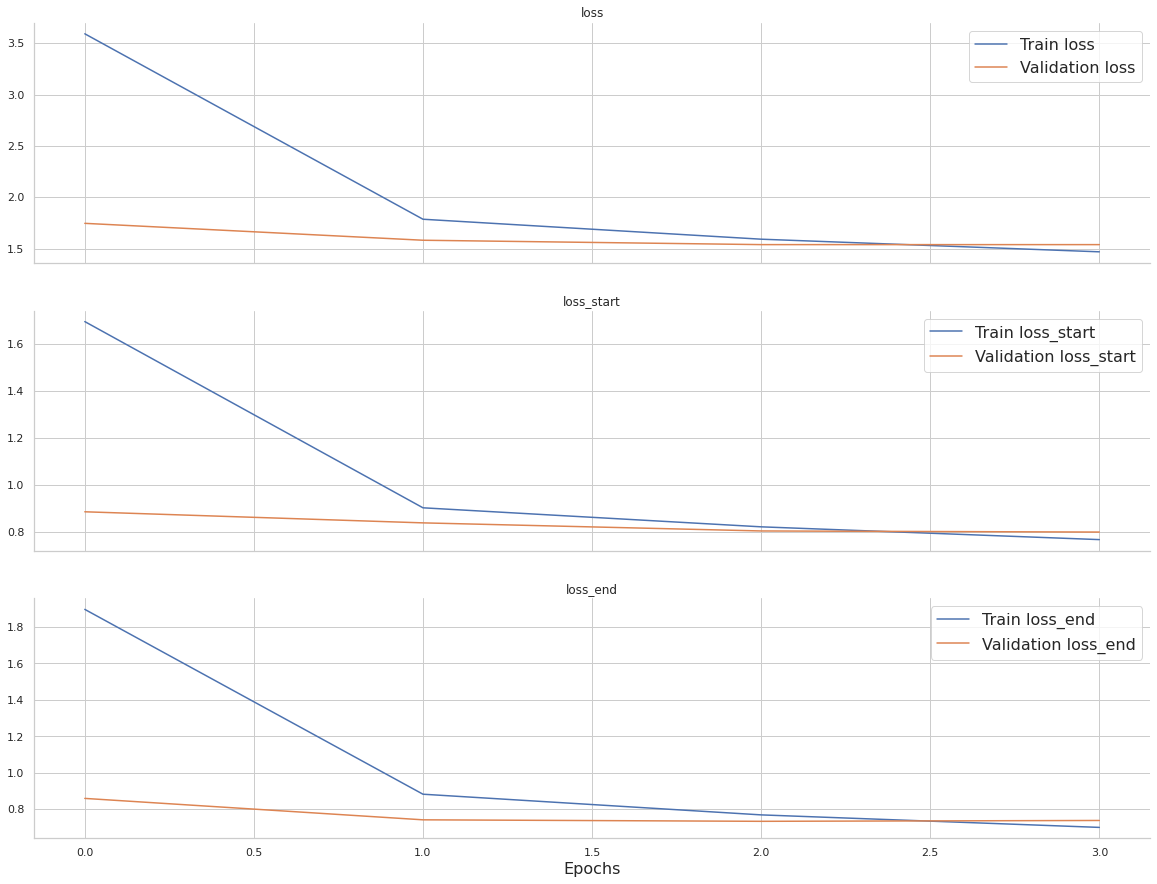

Fold: 2


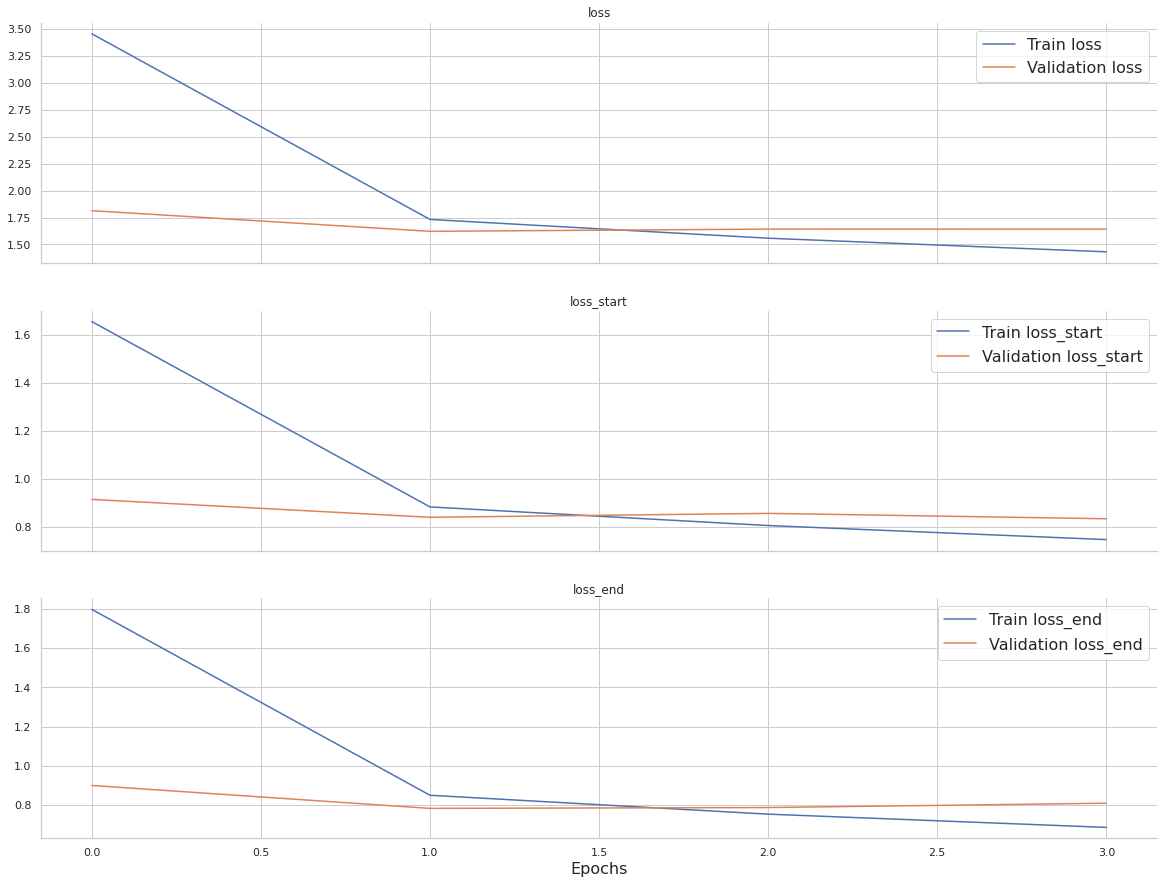

Fold: 3


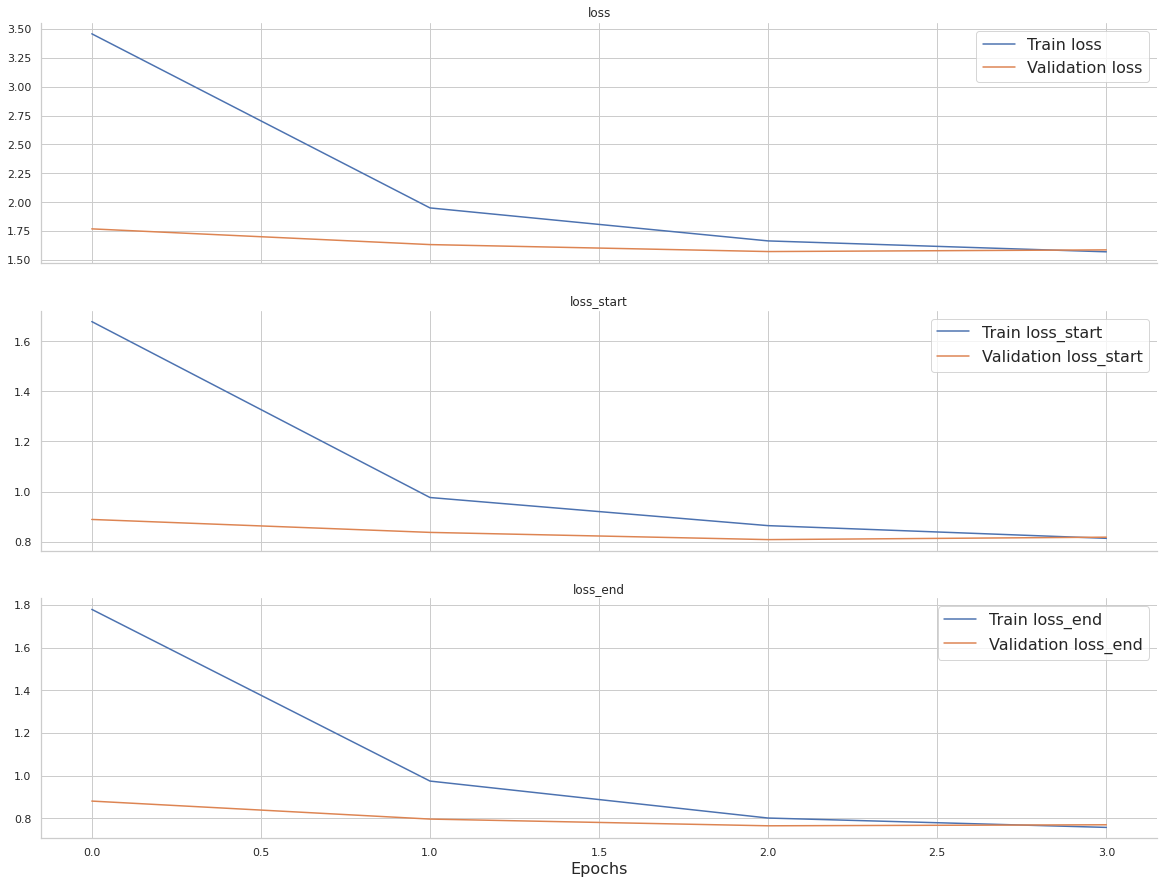

Fold: 4


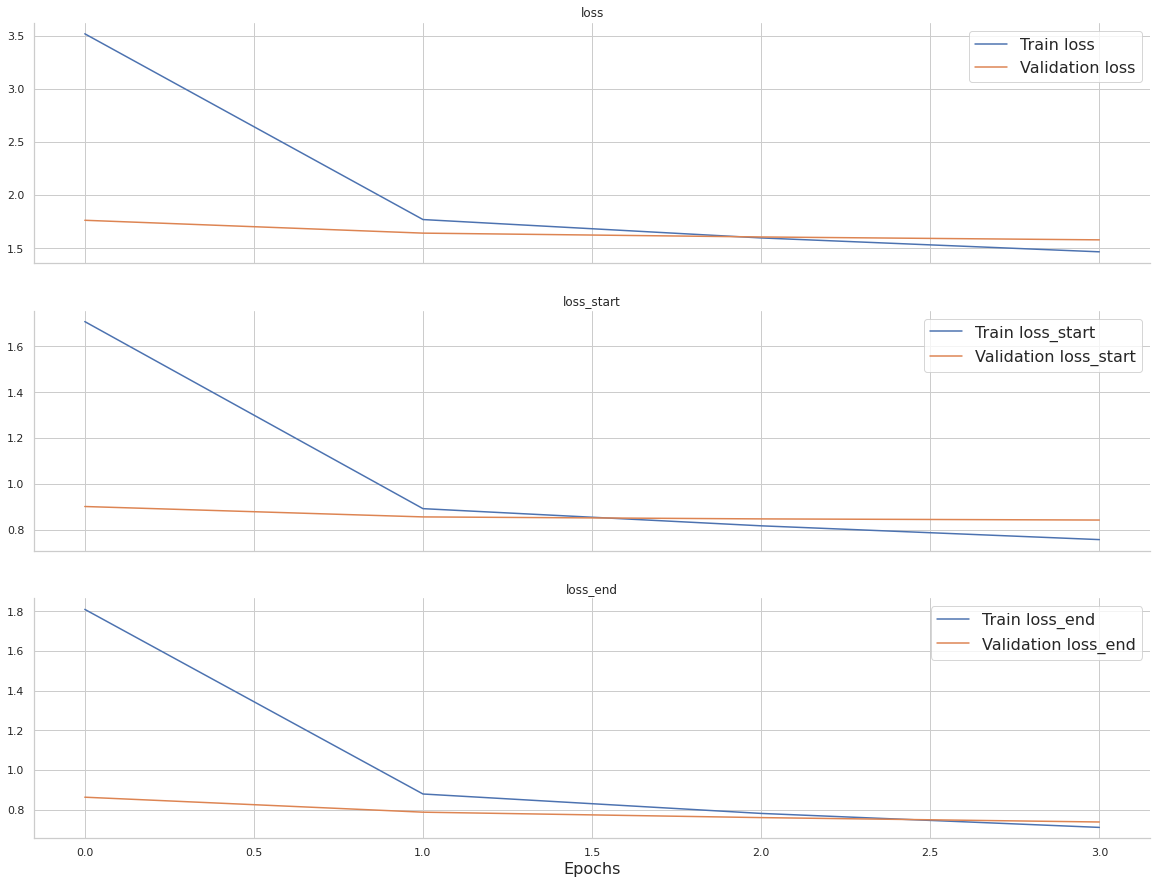

Fold: 5


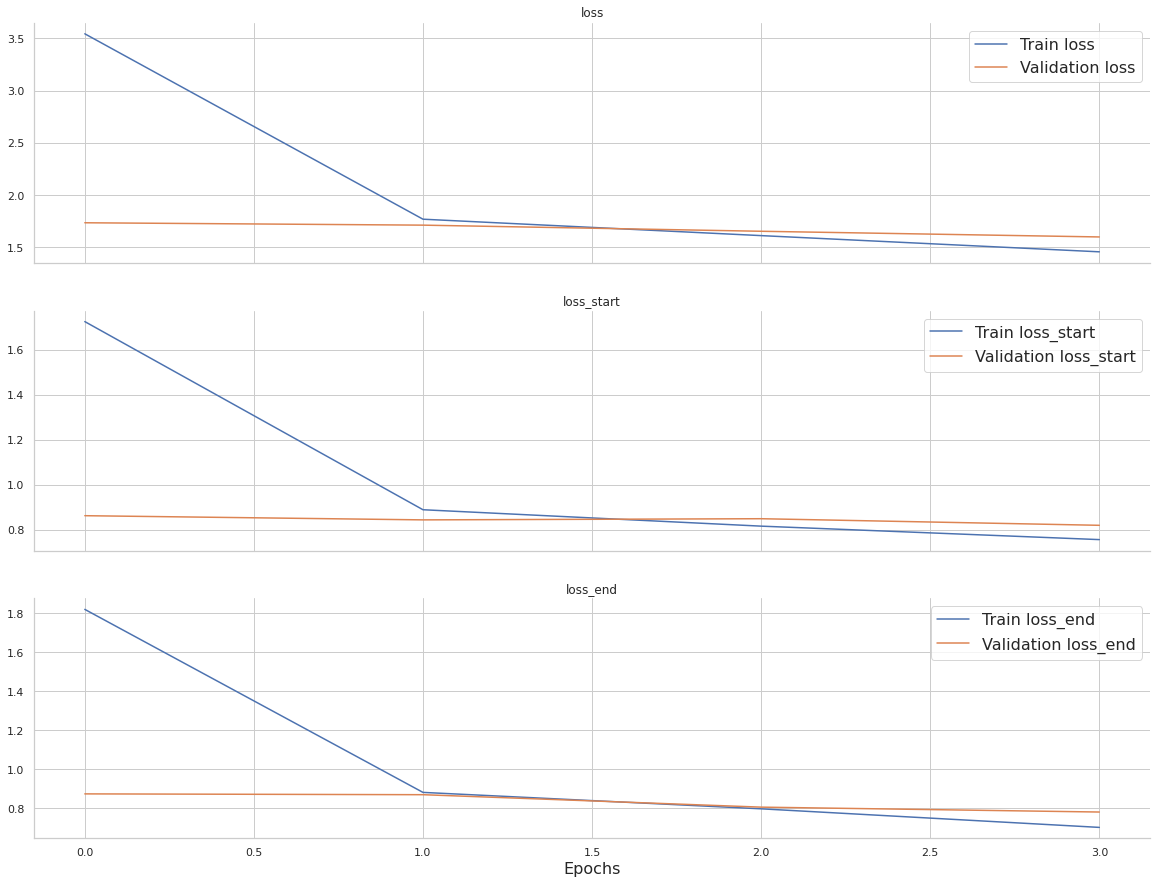

In [10]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [11]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.726594,0.700326,0.026268,0.732191,0.704889,0.723897,0.700203,0.717238,0.702981,0.731554,0.697514,0.728090,0.696046
Sentiment negative,0.561151,0.518039,0.043113,0.572541,0.516625,0.551884,0.516781,0.547509,0.524845,0.569097,0.522326,0.564727,0.509617
Sentiment neutral,0.974154,0.973289,0.000866,0.973722,0.973489,0.974352,0.973769,0.973697,0.974715,0.975270,0.971157,0.973731,0.973313
Sentiment positive,0.555909,0.512010,0.043899,0.564101,0.527483,0.555457,0.511972,0.538887,0.512594,0.563118,0.501987,0.557983,0.506015
0 <= text wordCnt < 3,0.861152,0.849080,0.012072,0.861597,0.805970,0.861862,0.857616,0.860391,0.855643,0.863636,0.849359,0.858275,0.876812
3 <= text wordCnt < 10,0.783272,0.763908,0.019364,0.788855,0.755859,0.780292,0.767213,0.774665,0.768867,0.789180,0.762711,0.783366,0.764887
10 <= text wordCnt < 30,0.691599,0.661433,0.030166,0.697831,0.673709,0.688327,0.661906,0.680927,0.664671,0.696628,0.655556,0.694283,0.651325
30 <= text wordCnt < 100,0.660893,0.608943,0.051951,0.644990,0.626729,0.699291,0.462756,0.671040,0.546945,0.654027,0.651242,0.635118,0.757040
0 <= selected text wordCnt < 3,0.632459,0.588197,0.044262,0.654361,0.603820,0.648769,0.611205,0.617543,0.586303,0.647530,0.590819,0.594093,0.548840


# Visualize predictions

In [12]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3,prediction_fold_4,jaccard_fold_4,prediction_fold_5,jaccard_fold_5
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,sooo sad,1.000000,sad,0.500000,sooo sad,1.000000,sooo sad,1.000000,sooo sad,1.000000
2,my boss is bullying me...,bullying me,negative,0.166667,bullying me...,0.333333,my boss is bullying me...,0.166667,my boss is bullying me...,0.166667,bullying me...,0.333333,my boss is bullying me...,0.166667
3,what interview! leave me alone,leave me alone,negative,0.600000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,what interview! leave me alone,0.600000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,"sons of ****,",1.000000,"sons of ****,",1.000000,"****,",0.333333,"sons of ****,",1.000000,"sons of ****,",1.000000
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000
6,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,0.500000,wow... u just became cooler.,1.000000,wow...,0.200000,wow...,0.200000,wow...,0.200000,wow...,0.200000
